In this notebook we will combine the malonylation, succinylation and glutylation results from muliple papers into a single table we can use for the enrichment analysis. This is useful since the UniProt database is severley lacking for these modifications

In [1]:
import pandas as pd
import os
import CGAT.IOTools as IOTools
import collections
import numpy as np
import urllib3
import json
import re
import csv
import appdirs
import bioservices
from bioservices import UniProt

from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

import proteomics.sequence as sequence

from time import gmtime, strftime

stats = importr('stats')
%load_ext rpy2.ipython

In [2]:
raw_base = '../raw/'
results = './results'

In [3]:
weinert_succ_inf = os.path.join(raw_base, 'Weinert_succinylation.csv')
weinert_acet_inf = os.path.join(raw_base, 'Weinert_acetylation.csv')

park_inf = os.path.join(raw_base, 'Park_succinylation.csv')

colaka_inf = os.path.join(raw_base, 'Colaka_malonylation.csv')

tan_inf = os.path.join(raw_base, 'Tan_glutarylation.csv')

rardin_inf = os.path.join(raw_base, 'Rardin_succinylation.csv')

nishida_inf = os.path.join(raw_base, 'Nishida_malonylation.csv')

cheng_inf = os.path.join(raw_base, 'Cheng_succinylation.csv')

sol_inf = os.path.join(raw_base, 'Sol_acetylation.csv')

sad_inf = os.path.join(raw_base, 'Sadhukhan_succinylation.csv')

sad_map_inf = os.path.join(raw_base, 'Sadhukhan_id_map.tab')

We need to generate a mapping from gene name to Uniprot ID. We can take the set of gene names in tan_inf and generate a list to pass to the uniprot online tool

In [4]:
tan_gene_names = os.path.join(results, 'tan_genes.tsv')
tan_gene_uniprot = os.path.join(results, 'tan_genes_uniprot.tsv')

p_set = set()
with IOTools.openFile(tan_gene_names, 'w') as outf:
    with IOTools.openFile(tan_inf, 'r') as inf:
        next(inf)
        for line in inf:
            p_set.update(line.strip().split('\t')[3].split(';'))
            
    for p in sorted(list(p_set)):
        outf.write("%s\n" % p)

Now we need to check the results are correct!

In [5]:
genename2uniprot = {}
with IOTools.openFile(tan_gene_uniprot, 'r') as inf:
    print(next(inf))
    for line in inf:
        line = line.strip().split('\t')
        gene_names = line[0].lower()
        uniprot_id = line[2]
        gene_description = line[5]
        for gene_name in gene_names.split(','):
            genename2uniprot[gene_name] = (uniprot_id, gene_description)

print(gene_name)
print(line)

yourlist:M201702088A530B6CA0138AFAA6D2B97CE8C2A924BFBC8BK	isomap:M201702088A530B6CA0138AFAA6D2B97CE8C2A924BFBC8BK	Entry	Entry name	Status	Protein names	Gene names	Organism	Length

mcg_9645
['CAT,MCG_9645', ',', 'A2AL20', 'A2AL20_MOUSE', 'unreviewed', 'Catalase (Catalase, isoform CRA_a)', 'Cat mCG_9645', 'Mus musculus (Mouse)', '176']


In [6]:
print(genename2uniprot['acadm'])
print(genename2uniprot['sod2'])
#print(genename2uniprot['es10'])

x = ['Ppa1', 'Pp', 'Pyp', 'Mrpl12', 'Rpml12']
for ix in x:
    try:
        print(genename2uniprot[ix.lower()])
    except:
        pass
    
print(genename2uniprot['rpml12'])

('Q91WS8', 'Acyl-Coenzyme A dehydrogenase, medium chain')
('Q4FJX9', 'Superoxide dismutase (EC 1.15.1.1)')
('Q9D819', 'Inorganic pyrophosphatase (EC 3.6.1.1) (Pyrophosphate phospho-hydrolase) (PPase)')
('Q9D819', 'Inorganic pyrophosphatase (EC 3.6.1.1) (Pyrophosphate phospho-hydrolase) (PPase)')
('Q9D819', 'Inorganic pyrophosphatase (EC 3.6.1.1) (Pyrophosphate phospho-hydrolase) (PPase)')
('Q9DB15', '39S ribosomal protein L12, mitochondrial (L12mt) (MRP-L12)')
('Q9DB15', '39S ribosomal protein L12, mitochondrial (L12mt) (MRP-L12)')
('Q9DB15', '39S ribosomal protein L12, mitochondrial (L12mt) (MRP-L12)')


In [7]:
checked = set()
more_than_one_match, no_matches, one_match = (0, 0, 0)
more_than_one_IPs = set()
one_match_IPs = set()
with IOTools.openFile(tan_inf, 'r') as inf:
    print(next(inf))
    for line in inf:

        line = line.strip().split('\t')
        gene_names = line[3].split(';')
        gene_description = line[4]

        matches = set()
        for gene in gene_names:
            
            if gene.lower() not in checked:
                try:
                    matches.add(genename2uniprot[gene.lower()][0])
                    checked.add(gene.lower())
                    #print(gene, gene_description, genename2uniprot[gene.lower()])
                except:
                    pass
                    #print('\nno entry for %s\n' % gene.lower())
            else:
                matches.add(genename2uniprot[gene.lower()][0])
                found_one = True
                
        if len(matches) == 0:
            no_matches += 1
            print('\nno matches\n')
            print(line)
            print(gene_names)
            print(gene_description, '\n\n')
        elif len(matches) > 1:
            more_than_one_match += 1
            more_than_one_IPs.add(line[1])
            #print('\nmore than one match!\n', line, matches, '\n\n')
        else:
            one_match += 1
            one_match_IPs.add(line[1])

print(len(more_than_one_IPs))
print(len(one_match_IPs))
print(one_match, more_than_one_match, no_matches)

Position	Leading Proteins	Protein Names	Gene Names	Protein Descriptions	Localization Prob	Score Diff	Number of Glutaryl (K)	Amino Acid	Sequence Window	PEP	Mascot Score	PTM Score	Modified Sequence	Glutaryl (K) Probabilities	Glutaryl (K) Score Diffs	Position in peptide	Charge	m/z	Mass Error [ppm]	Intensity


no matches

['535', 'IPI00267983', '', '', 'acyl-Coenzyme A dehydrogenase family, member 10-like', '1', '71.7598', '1', 'K', 'LGDDQLKVAKMEL', '8.99E-11', '71', '137.28', '_LGDDQLK(gl)VAK_', 'LGDDQLK(1)VAK', 'LGDDQLK(71.76)VAK(-71.76)', '7', '2', '600.82716', '-0.78734', '918990']
['']
acyl-Coenzyme A dehydrogenase family, member 10-like 



no matches

['542', 'IPI00267983', '', '', 'acyl-Coenzyme A dehydrogenase family, member 10-like', '1', '72.2061', '1', 'K', 'VAKMELKNQSRLQ', '2.8E-17', '40', '147.65', '_M(ox)ELK(gl)NQSR_', 'MELK(1)NQSR', 'MELK(72.21)NQSR', '4', '2', '568.27424', '-0.56587', '1203500']
['']
acyl-Coenzyme A dehydrogenase family, member 10-like 



no matches

['28

There are 684 lines in the Tan et al table, each representing a single modified peptide (from 195 proteins). Of these 159 proteins (576 lines) are converted into a single Uniprot ID, 33 (100 lines) are converted into multiple IDs and 3 (7 lines) don't contain a gene name.

For the 33 with multiple Uniprot IDs, we will assign the glutarylation event to each Uniprot ID. Note that there isn't any positional information

For the 3 proteins without a gene name assigned, we will perform a manual search in Uniprot:

cytochrome P450, family 2, subfamily w, polypeptide 1 ==>  E9Q816  http://www.uniprot.org/uniprot/E9Q816

Glycine N-acyltransferase-like protein;Acyl-CoA:glycine N-acyltransferase-like ==> Q9DCY0 http://www.uniprot.org/uniprot/Q9DCY0

similar to glutamate dehydrogenase ==> P26443 http://www.uniprot.org/uniprot/P26443

acyl-Coenzyme A dehydrogenase family, member 10-like;41 kDa protein ==> D3Z7X0 http://www.uniprot.org/uniprot/D3Z7X0
acyl-Coenzyme A dehydrogenase family, member 10-like ==> D3Z7X0 http://www.uniprot.org/uniprot/D3Z7X0


In [8]:
gene_description2UniprotId = {}
gene_description2UniprotId['cytochrome P450, family 2, subfamily w, polypeptide 1'] = 'E9Q816'
gene_description2UniprotId['Glycine N-acyltransferase-like protein'] = 'Q9DCY0'
gene_description2UniprotId['similar to glutamate dehydrogenase'] = 'P26443'
gene_description2UniprotId['acyl-Coenzyme A dehydrogenase family, member 10-like;41 kDa protein'] = 'D3Z7X0'
gene_description2UniprotId['acyl-Coenzyme A dehydrogenase family, member 10-like'] = 'D3Z7X0'
# Now we can write out the Tan et al table using this dictionary as a back up when no gene name is given

In [9]:
seq, method = sequence.getSequence('Q61694')
print(seq)
for position in [60, 70, 175, 203, 207, 352, 362, 244, 207, 350, 207, 350, 49, 60, 70, 207]:
    print(seq[position - 1])

MPGWSCLVTGAGGFLGQRIVRMLVQEEELQEIRALFRTFGRKHEEELSKLQTKAKVRVLKGDILDAQCLKRACQGMSAVIHTAAAIDPLGAASRQTILDVNLKGTQLLLDACVEASVPTFIYSSSVLVAGPNSYKEIILNAHEEEHRESTWPNPYPYSKRMAEKAVLATNGRLLKNGGTLHTCALRLPFIYGEECQVTSTTVKTALKNNSIIKKNATFSIANPVYVGNAAWAHILAARSLQDPKKSPSIQGQFYYISDNTPHQSYDDLNYTLSKEWGLCLDSGWSLPLSLLYWLAFLLETVSFLLRPVYNYRPPFNRLLITVLNSVFTISYKKAQRDLGYQPLVSWEEAKQKTSEWIGTLVKQHRETLHKKSQ
K
K
K
K
K
K
K
K
K
K
K
K
K
K
K
K


In [10]:
def parseRardinNishida(infile, out, ratio_index, p_value_index, peptide_index, k_shift, modification, reference):
    '''
    specific parser for Rardin et al and Nishida et al spreadsheets
    These contain peptides but not positions so we need to extract the protein sequences
    '''

    k_shift = str(k_shift)
    
    count_modified = 0
    count_lines = 0
    previous_protein = ""

    with IOTools.openFile(infile, 'r') as inf:
        lines = csv.reader(inf, delimiter=',', quotechar='"')
        next(lines)
        
        for line in lines:
            count_lines += 1
            
            protein = line[0]
            peptide = line[peptide_index]
            ratio = line[ratio_index]
            p_value = line[p_value_index]
            peptide_positions = []
            stripped_peptide = ""
            ix = 0
            base_ix = 0

            #if peptide != 'IIK[+100]EPVPDSGLLSLFQGQSPLTSC[+57]':
            #    continue

            while True:

                base = peptide[ix]

                stripped_peptide += base

                if ix == len(peptide) - 1:
                    break

                elif base == 'K' and peptide[ix+1: ix+4+len(k_shift)] == "[+%s]" % k_shift:
                    peptide_positions.append(base_ix)
                    count_modified += 1
                    base_ix += 1
                    ix += 4 + len(k_shift)
                    if ix == len(peptide):
                        break
                elif peptide[ix+1] == "[":
                    base_ix += 1
                    while True:
                        ix += 1
                        if peptide[ix+1] == "]":
                            ix += 2
                            break
                    if ix == len(peptide):
                        break
                else:
                    base_ix += 1
                    ix += 1


            if protein != previous_protein:
                previous_protein = protein
                seq, method = sequence.getSequence(protein)


            protein_position = seq.find(stripped_peptide)

            if protein_position == -1:

                print(ratio)
                print(line)
                print(peptide)
                print(protein_position)
                print(stripped_peptide)

                print(protein)
                print(peptide)

                print(seq)
                print(seq.find(stripped_peptide))

            else:
                for peptide_position in peptide_positions:
                    position = protein_position + 1 + peptide_position
                    outf.write("%s\n" % '\t'.join(
                            [protein, str(position), modification, reference, str(ratio), str(p_value)]))
    
    return count_modified

In [11]:
# make mapping dictionary between GI id and Uniprot ID
GI2Uniprot = {}

with IOTools.openFile(sad_map_inf, 'r') as inf:
    lines = csv.reader(inf, delimiter='\t', quotechar='"')
    next(lines)
    for line in lines:
        GI2Uniprot[line[0]] = line[2]
        
print(GI2Uniprot)
print(len(GI2Uniprot))

{'18079339': 'Q99KI0', '6681095': 'P62897', '188035915': 'Q9DBF1', '31982300': 'P02088', '6755114': 'P99029', '21704100': 'Q99JY0', '6680690': 'P20108', '6679261': 'P35486', '102468565': 'Q9JLT4', '18250284': 'Q9D6R2', '38142460': 'Q9DCW4', '225543103': 'Q8CHT0', '31982856': 'O08749', '21699068': 'Q8K411', '257796245': 'Q8BMF4', '21313679': 'Q9DCX2', '31981810': 'P42125', '33859811': 'Q8BMS1', '226823367': 'P97807', '225579033': 'P54071', '254540162': 'Q91ZA3', '29126205': 'Q8BWT1', '256220343': 'Q99LB2', '9789985': 'Q9JHI5', '6680618': 'P45952', '6680027': 'P26443', '183396771': 'P63038', '116268115': 'Q9JLZ3', '21450129': 'Q8QZT1', '170172520': 'P53395', '6754036': 'P05202', '21313536': 'Q9D2G2', '31982522': 'Q07417', '31982186': 'P08249', '13385942': 'Q9CZU6', '238624114': 'Q9QYR9', '20070412': 'Q9DB20', '162461907': 'P38647', '6753810': 'P11404', '31980762': 'P09671', '31980648': 'P56480', '255708423': 'P04247', '31980744': 'Q9CPQ8', '31982520': 'P51174', '18152793': 'Q9D051', '217

In [12]:
n1 = 0
n2 = 0
with IOTools.openFile(sad_inf, 'r') as inf:
    lines = csv.reader(inf, delimiter='\t', quotechar='"')
    next(lines)
    for line in lines:
        try:
            protein = GI2Uniprot[line[3]]
            n1 += 1
        except KeyError:
            n2 += 1
            continue
    

In [13]:
outfile = os.path.join(results, 'lysine_modification.tsv')

In [14]:
outf = IOTools.openFile(outfile, 'w')
outf.write("%s\n" % '\t'.join(['Protein', 'Position', 'Modification', 'Reference', 'ratio', 'p_value']))

54

In [15]:
with IOTools.openFile(sad_inf, 'r') as inf:
    lines = csv.reader(inf, delimiter='\t', quotechar='"')
    next(lines)
    for line in lines:
        
        try:
            protein = GI2Uniprot[line[3]]
        except KeyError:
            print('No ID match:')
            print(line)
            continue

        peptide = line[0]
        ratio = line[2]
        ix, base_ix = 0,0

        peptide_positions = []

        if len(protein) == 0:
            continue

        for modification in line[1].split("; "):
            if '(Succinyl)' in modification:
                peptide_positions.append(int(modification.replace('(Succinyl)', '')[1:]))

        seq, method = sequence.getSequence(protein)

        if seq is None:
            continue

        try:
            protein_position = seq.find(peptide)
        except:
            print(seq, method, protein)
            raise ValueError()

        if protein_position == -1:
            continue

        for peptide_position in peptide_positions:
                position = protein_position + peptide_position
                outf.write("%s\n" % '\t'.join(
                        [protein, str(position), 'succinylation', 'Sadhukhan_et_al_2016', ratio, "-1"]))


No ID match:
['SNIKAAWGK', 'N-Term(Dimethyl); K4(Succinyl); K9(Dimethyl)', '0.43', '145301578', 'hemoglobin subunit alpha [Mus musculus]']
No ID match:
['GVTEAHVDQKNK', 'N-Term(Dimethyl); K10(Succinyl); K12(Dimethyl)', '6.25', '149274887', 'PREDICTED: ES1 protein homolog, mitochondrial-like isoform 2 [Mus musculus]']
No ID match:
['GLVAVVTGGASGLGLATAKR', 'N-Term(Dimethyl); K19(Succinyl)', '1.34', '61888838', '3-hydroxyacyl-CoA dehydrogenase type-2 [Mus musculus]']


In [16]:
count_modified = 0
c = ""
n = 0
current_protein = ""
with IOTools.openFile(sol_inf, 'r') as inf:
    lines = csv.reader(inf, delimiter='\t', quotechar='"')
    next(lines)
    next(lines)
    next(lines)
    for line in lines:
        n+=1
        proteins = line[7].split(";")
        peptide = line[12].replace("_", "")
        ratio = line[18]
        ix, base_ix = 0,0
        stripped_peptide = ""
        peptide_positions = []
        
        if len(proteins) == 0:
            continue
        
        while True:
            base = peptide[ix]
            stripped_peptide += base

            if ix == len(peptide) - 1:
                break

            elif base == 'K' and peptide[ix+1: ix+5] == "(ac)":
                peptide_positions.append(base_ix)
                count_modified += 1
                base_ix += 1
                ix += 5
                if ix == len(peptide):
                    break
            else:
                base_ix += 1
                ix += 1
        
        for protein in proteins:
            
            if len(protein.split("-")) > 1 and protein.split("-")[0] in proteins:
                continue
            
            if protein != current_protein:
                current_protein = protein
                seq, method = sequence.getSequence(protein)
            
            if seq is None:
                continue
            
            try:
                protein_position = seq.find(stripped_peptide)
            except:
                print(seq, method, protein)
                raise ValueError()
            
            if protein_position == -1:
                continue
            
            for peptide_position in peptide_positions:
                    position = protein_position + 1 + peptide_position
                    outf.write("%s\n" % '\t'.join(
                            [protein, str(position), 'acetylation', 'Sol_et_al_2012', ratio, "-1"]))

        if n % 50 == 0:
            print('lines done: %i %s' % (
                   n, strftime("%Y-%m-%d %H:%M:%S", gmtime())))


lines done: 50 2017-03-30 15:41:51
lines done: 100 2017-03-30 15:42:09
lines done: 150 2017-03-30 15:42:20
lines done: 200 2017-03-30 15:42:39
lines done: 250 2017-03-30 15:42:54
lines done: 300 2017-03-30 15:43:05
lines done: 350 2017-03-30 15:43:23
lines done: 400 2017-03-30 15:43:38
lines done: 450 2017-03-30 15:43:52
lines done: 500 2017-03-30 15:44:07
lines done: 550 2017-03-30 15:44:26
lines done: 600 2017-03-30 15:44:37
lines done: 650 2017-03-30 15:45:02
lines done: 700 2017-03-30 15:45:15
lines done: 750 2017-03-30 15:45:31
lines done: 800 2017-03-30 15:45:47
lines done: 850 2017-03-30 15:46:16
lines done: 900 2017-03-30 15:46:33
lines done: 950 2017-03-30 15:46:41
lines done: 1000 2017-03-30 15:47:08
lines done: 1050 2017-03-30 15:47:22
lines done: 1100 2017-03-30 15:47:40
lines done: 1150 2017-03-30 15:47:55
lines done: 1200 2017-03-30 15:48:09
lines done: 1250 2017-03-30 15:48:27
lines done: 1300 2017-03-30 15:48:43
lines done: 1350 2017-03-30 15:48:59
lines done: 1400 2017

In [17]:
checked = set()

with IOTools.openFile(tan_inf, 'r') as inf:
    lines = csv.reader(inf, delimiter='\t', quotechar='"')
    next(lines)
    for line in lines:
        gene_names = line[3].split(';')
        gene_description = line[4]

        matches = set()
        for gene in gene_names:
            
            if gene.lower() not in checked:
                try:
                    matches.add(genename2uniprot[gene.lower()][0])
                    checked.add(gene.lower())

                except:
                    pass

            else:
                matches.add(genename2uniprot[gene.lower()][0])
        
        
        if len(matches) == 0:
            matches = (gene_description2UniprotId[gene_description],)

        for match in matches:
            outf.write("%s\n" % '\t'.join([match, '', 'glutarylation', 'Tan_et_al_2014', "-1", "-1"]))
            

In [18]:
count_succ = parseRardinNishida(rardin_inf, outf, 10, 11, 4, 100, 'succinylation', 'Rardin_et_al_2013')
count_malon = parseRardinNishida(nishida_inf, outf, 19, 20, 5, 86, 'malonylation', 'Nishida_et_al_2015')
print(count_succ, count_malon)


996 1043


In [19]:
with IOTools.openFile(weinert_succ_inf, 'r') as inf:
    lines = csv.reader(inf, delimiter=',', quotechar='"')
    next(lines)
    for line in lines:
        protein = line[3]
        position = line[4]
        outf.write("%s\n" % '\t'.join([protein, position, 'succinylation', 'Weinert_et_al_2013', "-1", "-1"]))
                
#this is a mess. Sort it out!!!
with IOTools.openFile(weinert_acet_inf, 'r') as inf:
    lines = csv.reader(inf, delimiter=',', quotechar='"')
    next(lines)
    for line in lines:
        proteins = [line[3]]
        if len(proteins[0]) > 0:
            try:
                positions = [line[2].split(";")[line[1].split(";").index(proteins[0])]]
            except:
                proteins = line[1].split(";")
                positions = line[2].split(";")
        else:
            proteins = line[1].split(";")
            positions = line[2].split(";")

        for protein, position in zip(proteins, positions):
            outf.write("%s\n" % '\t'.join([protein, position, 'acetylation', 'Weinert_et_al_2013', "-1", "-1"]))

In [20]:
with IOTools.openFile(park_inf, 'r') as inf:
    lines = csv.reader(inf, delimiter=',', quotechar='"')
    next(lines)
    for line in lines:

        if len(line[3]) > 0:
            proteins = [line[3]]
            positions = [line[1].split(";")[line[0].split(";").index(proteins[0])]]

        else:
            proteins = line[0].split(";")
            positions = line[1].split(";")
        
        KO_only = line[18] == 'Sirt5 KO Only'
        ratio = line[24]
        if ratio == "-" or KO_only:
            ratio = "-1"

        if KO_only:
            for protein, position in (zip(proteins, positions)):
                outf.write("%s\n" % '\t'.join([protein, position, 'succinylation_SIRT5_KO', 'Park_et_al_2013', ratio, "-1"]))
        else:
            if len(line[3])==0 in proteins:
                print(line)
                print(len(line))
                print(proteins)
                print(positions)
                print(ratio)
                print([(x,y) for x,y in zip(proteins, positions)])
                print("")
            for protein, position in (zip(proteins, positions)):
                outf.write("%s\n" % '\t'.join([protein, position, 'succinylation', 'Park_et_al_2013', ratio, "-1"]))

In [21]:
with IOTools.openFile(colaka_inf, 'r') as inf:
    lines = csv.reader(inf, delimiter='\t', quotechar='"')
    next(lines)
    for line in lines:
        proteins = line[0]
        positions = line[28]
        if len(proteins)>1:
            for protein, position in (zip(proteins.split(';'), positions.split(';'))):
                outf.write("%s\n" % '\t'.join([protein, position, 'malonylation', 'Colaka_et_al_2015', "-1", "-1"]))

In [22]:
outf.close()

In [23]:
lysine_df = pd.read_table(outfile, sep='\t')
print(lysine_df.head())
print(set(lysine_df['Reference']))
print(collections.Counter(lysine_df['Reference']))

  Protein  Position   Modification             Reference  ratio  p_value
0  Q9JLT4     337.0  succinylation  Sadhukhan_et_al_2016   1.47     -1.0
1  Q61425     179.0  succinylation  Sadhukhan_et_al_2016   1.07     -1.0
2  Q61425     241.0  succinylation  Sadhukhan_et_al_2016   1.33     -1.0
3  Q9JLZ3     179.0  succinylation  Sadhukhan_et_al_2016   4.70     -1.0
4  Q9CZU6     450.0  succinylation  Sadhukhan_et_al_2016  57.68     -1.0
{'Weinert_et_al_2013', 'Sadhukhan_et_al_2016', 'Colaka_et_al_2015', 'Sol_et_al_2012', 'Rardin_et_al_2013', 'Park_et_al_2013', 'Tan_et_al_2014', 'Nishida_et_al_2015'}
Counter({'Weinert_et_al_2013': 6221, 'Sol_et_al_2012': 4848, 'Colaka_et_al_2015': 4209, 'Park_et_al_2013': 1085, 'Nishida_et_al_2015': 1043, 'Rardin_et_al_2013': 996, 'Tan_et_al_2014': 825, 'Sadhukhan_et_al_2016': 119})


In [70]:
print(lysine_df[lysine_df['Protein']=='Q9JLT4'])

      Protein  Position   Modification             Reference  ratio  p_value
0      Q9JLT4     337.0  succinylation  Sadhukhan_et_al_2016   1.47     -1.0
5208   Q9JLT4       NaN  glutarylation        Tan_et_al_2014  -1.00     -1.0
5209   Q9JLT4       NaN  glutarylation        Tan_et_al_2014  -1.00     -1.0
5210   Q9JLT4       NaN  glutarylation        Tan_et_al_2014  -1.00     -1.0
5211   Q9JLT4       NaN  glutarylation        Tan_et_al_2014  -1.00     -1.0
5212   Q9JLT4       NaN  glutarylation        Tan_et_al_2014  -1.00     -1.0
9111   Q9JLT4     337.0  succinylation    Weinert_et_al_2013  -1.00     -1.0
9112   Q9JLT4     215.0  succinylation    Weinert_et_al_2013  -1.00     -1.0
9113   Q9JLT4     329.0  succinylation    Weinert_et_al_2013  -1.00     -1.0
12503  Q9JLT4     215.0    acetylation    Weinert_et_al_2013  -1.00     -1.0
12840  Q9JLT4     329.0    acetylation    Weinert_et_al_2013  -1.00     -1.0
14136  Q9JLT4     337.0  succinylation       Park_et_al_2013  -1.00     -1.0

In [24]:
lysine_df_pivot = lysine_df.pivot_table(values='Reference', index='Protein', columns='Modification',
                                        aggfunc=lambda x: len(x)>0)

lysine_df_pivot = lysine_df_pivot.applymap(lambda x: 1 if x else 0)

In [25]:
lysine_df_pivot2 = lysine_df.pivot_table(values='Reference', index=['Protein', 'Position'], columns='Modification',
                                        aggfunc=lambda x: len(x)>0)

lysine_df_pivot2 = lysine_df_pivot2.applymap(lambda x: 1 if x else 0)

In [26]:
print(lysine_df_pivot2.head())
print(lysine_df_pivot2[[x==3 for x in lysine_df_pivot2.apply(sum, 1).tolist()]].head())
print(lysine_df_pivot2[[x==3 for x in lysine_df_pivot2.apply(sum, 1).tolist()]].shape)
competitive_modifications = lysine_df_pivot2[
            [x==3 for x in lysine_df_pivot2[['acetylation', 'malonylation', 'succinylation']].apply(
                sum, 1).tolist()]
        ].index.get_level_values('Protein').unique()

Modification      acetylation  malonylation  succinylation  \
Protein Position                                             
A0AUV1  5.0                 1             0              0   
        9.0                 1             0              0   
        95.0                1             0              0   
        118.0               1             0              0   
A0JLP6  335.0               1             0              0   

Modification      succinylation_SIRT5_KO  
Protein Position                          
A0AUV1  5.0                            0  
        9.0                            0  
        95.0                           0  
        118.0                          0  
A0JLP6  335.0                          0  
Modification      acetylation  malonylation  succinylation  \
Protein Position                                             
A2AS89  223.0               1             1              1   
A6ZI44  96.0                1             1              1   
B1ATI0  296.0   

In [27]:
print(len(competitive_modifications))

269


In [28]:
print(lysine_df_pivot.head())
print(lysine_df_pivot.tail())
print(lysine_df_pivot[lysine_df_pivot.apply(sum, 1)==4].head())
print(lysine_df_pivot[lysine_df_pivot.apply(sum, 1)==4].shape)
print(lysine_df_pivot[lysine_df_pivot.apply(sum, 1)!=4].shape)

Modification  acetylation  glutarylation  malonylation  succinylation  \
Protein                                                                 
A0AUV1                  1              0             0              0   
A0JLP6                  1              0             0              0   
A0JLR7                  1              0             0              0   
A0JLT5                  1              0             0              0   
A0JLV3                  1              0             0              0   

Modification  succinylation_SIRT5_KO  
Protein                               
A0AUV1                             0  
A0JLP6                             0  
A0JLR7                             0  
A0JLT5                             0  
A0JLV3                             0  
Modification  acetylation  glutarylation  malonylation  succinylation  \
Protein                                                                 
Q9Z2Z6                  1              0             0              1

In [29]:
lysine_df_pivot['all_modifications'] = [x == 4 for x in lysine_df_pivot[
        ['acetylation', 'glutarylation', 'malonylation', 'succinylation']].apply(sum, 1)]

lysine_df_pivot['all_modifications'] = [x == 3 for x in lysine_df_pivot[
        ['acetylation', 'malonylation', 'succinylation']].apply(sum, 1)]

lysine_df_pivot['all_modifications'] = lysine_df_pivot['all_modifications'].astype(int)

In [30]:
lysine_df_pivot['competitive_modifications'] = [x in competitive_modifications for x in lysine_df_pivot.index]
lysine_df_pivot['competitive_modifications'] = lysine_df_pivot['competitive_modifications'].astype(int)

In [31]:
print(lysine_df_pivot.head())
print(lysine_df_pivot[lysine_df_pivot['all_modifications'] == True].head())
print(lysine_df_pivot[lysine_df_pivot['all_modifications'] == True].shape)
print(lysine_df_pivot[lysine_df_pivot['competitive_modifications'] == True].shape)

Modification  acetylation  glutarylation  malonylation  succinylation  \
Protein                                                                 
A0AUV1                  1              0             0              0   
A0JLP6                  1              0             0              0   
A0JLR7                  1              0             0              0   
A0JLT5                  1              0             0              0   
A0JLV3                  1              0             0              0   

Modification  succinylation_SIRT5_KO  all_modifications  \
Protein                                                   
A0AUV1                             0                  0   
A0JLP6                             0                  0   
A0JLR7                             0                  0   
A0JLT5                             0                  0   
A0JLV3                             0                  0   

Modification  competitive_modifications  
Protein                         

In [32]:
lysine_df_pivot.to_csv(os.path.join(results, 'lysine_modification_summary.tsv'), sep='\t')

Next we use the localisations from the hyperlopit data


In [33]:
%%R
library(ggplot2)
hyperlopit_inf = '/home/FILESERVER5/proteomics/tss38/anaconda3/lib/R/library/pRolocdata/extdata/hyperLOPIT-SIData-ms3-rep12-intersect.csv.gz'
#header1 <- scan(hyperlopit_inf, nlines = 1, what = character(), sep=',')
#header2 <- scan(hyperlopit_inf, skip = 1, nlines = 1, what = character(), sep=',')
#header_lines <- gsub(" ", ".", gsub(" - $", "", (gsub("^ - ", "", paste(header1, header2, sep=' - ')))))
#print(header_lines)
#hyperlopit <- read.table(hyperlopit_inf, sep=',', header=F, skip=2)
#colnames(hyperlopit) <- header_lines
#hyperlopit <- hyperlopit[,c('UniProt.Accession.for.Protein.Group', 'Final.Localization.Assignment')]
#colnames(hyperlopit) <- c('uniprotID', 'Localization')

In [34]:
df = pd.read_table('~/WT/NML/hyperLOPIT-enrichment/R/hl_subset.tsv', sep='\t')
print(df.shape)

(4413, 94)


In [35]:
%%R
n <- count.fields(hyperlopit_inf, sep='\t', blank.lines.skip=FALSE)
hyperlopit_inf = '~/WT/NML/hyperLOPIT-enrichment/R/hl_subset.tsv'
hyperlopit_df = read.table(hyperlopit_inf, sep='\t', header=T, quote = "", comment.char = "")
print(dim(hyperlopit_df))

hyperlopit_df <- hyperlopit_df[,c('uniprot.accession', 'Final.Localization.Assignment')]
print(head(hyperlopit_df))
print(dim(hyperlopit_df))

[1] 4413   94
  uniprot.accession Final.Localization.Assignment
1            Q9JHU4                  unclassified
2            Q9ERU9           Nucleus - Chromatin
3            P26039            Actin cytoskeleton
4            Q8BTM8                  unclassified
5            A2ARV4                  unclassified
6            Q80X90                  unclassified
[1] 4413    2


Now we merege in the modification data

In [36]:
%%R -i lysine_df_pivot
lysine_df_pivot$uniprotID <- rownames(lysine_df_pivot)
#rownames(lysine_df_pivot) <- 1:length(rownames(lysine_df_pivot))
print(head(lysine_df_pivot))
print(head(hyperlopit_df))
merged_df <- merge(hyperlopit_df, lysine_df_pivot, by.x='uniprot.accession', by.y='uniprotID', all.x=T)
rownames(merged_df) <- merged_df$uniprot.accession
merged_df[is.na(merged_df)] <- 0
print(head(merged_df))
print('P52480' %in% rownames(merged_df))
print(dim(merged_df))
print(dim(hyperlopit_df))


       acetylation glutarylation malonylation succinylation
A0AUV1           1             0            0             0
A0JLP6           1             0            0             0
A0JLR7           1             0            0             0
A0JLT5           1             0            0             0
A0JLV3           1             0            0             0
A0JNS9           1             0            0             0
       succinylation_SIRT5_KO all_modifications competitive_modifications
A0AUV1                      0                 0                         0
A0JLP6                      0                 0                         0
A0JLR7                      0                 0                         0
A0JLT5                      0                 0                         0
A0JLV3                      0                 0                         0
A0JNS9                      0                 0                         0
       uniprotID
A0AUV1    A0AUV1
A0JLP6    A0JLP6
A0JLR7    A

In [37]:
%%R 
cyt_succ <- rownames(merged_df[(merged_df$Final.Localization.Assignment=='Cytosol' & merged_df$succinylation==1),])
cyt_all <- rownames(merged_df[(merged_df$Final.Localization.Assignment=='Cytosol'),])
print(length(cyt_succ))
print(length(cyt_all))

[1] 78
[1] 322


Now we need the data from the E-cadherin interactome. We need to parse this data first so we'll do this in python then read into R from a flat file. In particular, we only want to rank the protein which we have hyperLOPIT data for.

In [38]:
hyperlopit_proteins = set()
hyperlopit_inf = '/home/FILESERVER5/proteomics/tss38/WT/NML/hyperLOPIT-enrichment/R/hl_subset.tsv'
with IOTools.openFile(hyperlopit_inf, 'r') as inf:
    header = next(inf).strip().split('\t')
    
    uniprot_accession_ix = header.index('uniprot_ID')

    for line in inf:
        line = line.strip().split('\t')
        hyperlopit_proteins.add(line[uniprot_accession_ix])
        if len(line[uniprot_accession_ix].split(';')) > 1:
            print(line)
            print(line[uniprot_accession_ix].split(';'))
            break

print(len(hyperlopit_proteins))

4413


In [39]:
ECadherin_inf = os.path.join(raw_base, "ECadherin_interactome_glass.csv")

retained = 0
discarded = set()

with IOTools.openFile(os.path.join(raw_base, 'ECadherin_interactome_glass_parsed.tsv'), 'w') as outf:
    with IOTools.openFile(ECadherin_inf, 'r') as inf:
        rank = 1
        next(inf) # skip header
        outf.write('Uniprot_ID\tRank\n')
        for line in inf:
            line = line.strip().split('\t')
            ids = line[0].split(';')
            for uni_id in ids:
                if uni_id in hyperlopit_proteins:
                    retained += 1
                else:
                    discarded.add(uni_id)

print(retained, len(discarded))
print(list(hyperlopit_proteins)[0:10])
print(list(discarded)[0:10])

0 11539
['Q8JZK9', 'Q8BKE6', 'P97765', 'Q9QXT0', 'Q9D1M7', 'P68254', 'Q5NC05', 'Q9JJ80', 'O35685', 'Q3UYV9']
['Q9UN86', 'P78371-2', 'Q4VBA9', 'Q96N67-5', 'B4DT13', 'J3KTF0', 'C9JRL4', 'E7EPS4', 'H0YGV7', 'H7C229']


Of course! The E-Cadherin data is from a human cell line. We need to find all the human orthologs for our mouse genes first then. I can't find any database linking uniprot IDs for humnan and mouse but this links Ensembl protein IDs:
http://www.treefam.org/download#tabview=tab1

So we need to convert the uniprot IDs to Ensemble protein IDs. We can do this with the downloads from Uniprot to map uniprot IDs to Ensemble IDs:


In [40]:
orthologs_inf = os.path.join(raw_base, 'Homo_sapiens-Mus_musculus.txt')
mmUni2Ens_inf = os.path.join(raw_base, 'MOUSE_10090_idmapping_selected.tab')
hgUni2Ens_inf = os.path.join(raw_base, 'HUMAN_9606_idmapping_selected.tab')

In [41]:
mouse2humanEnsPro = collections.defaultdict(set)


with IOTools.openFile(orthologs_inf, 'r') as inf:
    for line in inf:
        line = line.strip().split('\t')
        if line[5] == 'ortholog':
            
            if line[1] == 'Homo sapiens':
                human_id = line[0]
                mouse_id = line[2]

            elif line[1] == 'Mus musculus':
                human_id = line[2]
                mouse_id = line[0]

            else:
                raise ValueError(line)

            mouse2humanEnsPro[mouse_id].add(human_id)

# some mouse IDs map to multiple human IDs. In many cases these will both map to the same uniprot ID
#s o this is not an issue. We can track this following conversion
print(mouse2humanEnsPro['ENSMUSP00000107237'])

{'ENSP00000319690', 'ENSP00000365370'}


In [42]:
mouseUni2Ens = {}
no_id = 0
yes_id = 0
with IOTools.openFile(mmUni2Ens_inf, 'r') as inf:
    for line in inf:
        line = line.strip().split("\t")
        uni_id = line[0]
        try:
            yes_id += 1
            ens_ids = line[20].split('; ')
            mouseUni2Ens[uni_id] = ens_ids
        except:
            no_id += 1

print(no_id)
print(yes_id)

5411
80930


In [43]:
humanEns2Uni = collections.defaultdict(set)
no_id = 0
yes_id = 0
with IOTools.openFile(hgUni2Ens_inf, 'r') as inf:
    for line in inf:
        line = line.strip().split("\t")
        uni_id = line[0]
        try:
            yes_id += 1
            ens_ids = line[20].split('; ')
            for ens_id in ens_ids:
                humanEns2Uni[ens_id].add(uni_id)
        except:
            no_id += 1

print(no_id)
print(yes_id)


28487
156710


In [44]:
# P52480 = mouse PKM
# P14618 = mouse PKM
for ens_id in mouseUni2Ens['P52480']:
    print(ens_id)
    print(mouse2humanEnsPro[ens_id])
    for human_ens in mouse2humanEnsPro[ens_id]:
        print(humanEns2Uni[human_ens])
# This is working all OK for PKM!

ENSMUSP00000034834
{'ENSP00000320171'}
{'P14618'}
ENSMUSP00000128770
set()


In [45]:
print(mouse2humanEnsPro['ENSMUSP00000074500'])
print(mouse2humanEnsPro['ENSP00000320171'])

set()
set()


In [46]:
print(len(hyperlopit_proteins))

mmUni2Ens_matched, mm2hgUni_matched, hgEns2Uni_matched  = (0, 0, 0)
hyperlopit_proteins_matched = 0

hg_hyperlopit_proteins = set()

for protein in hyperlopit_proteins:
    matches = set()
    try:
        ens_ids = mouseUni2Ens[protein]
        if len(ens_ids) > 0 :
            mmUni2Ens_matched +=1 
            for ens_id in ens_ids:
                human_ens = mouse2humanEnsPro[ens_id]

                if len(human_ens) > 0:
                    mm2hgUni_matched += 1
                    
                    for human_en in human_ens:
                        humanUnis = humanEns2Uni[human_en]
                        #print(human_en)
                        #print(humanUnis)

                        if len(humanUnis) > 0:
                            hgEns2Uni_matched += 1
                            matches.update(humanUnis)
                            #print(matches)
                else:
                    #print(ens_ids)
                    #print(ens_id)
                    #print(human_ens)
                    #break
                    pass

        if len(matches) > 0:
            hyperlopit_proteins_matched += 1
            hg_hyperlopit_proteins.update(matches)
                
   
    except:
        print('protein not found in uniprot mapping file: ', protein)

print(mmUni2Ens_matched, mm2hgUni_matched, hgEns2Uni_matched)
print(hyperlopit_proteins_matched)
print(len(hg_hyperlopit_proteins))
            

4413
protein not found in uniprot mapping file:  Q9DCV5
protein not found in uniprot mapping file:  Q9D365
protein not found in uniprot mapping file:  Q8JZS9
protein not found in uniprot mapping file:  P11260
4409 3732 3733
3621
3704


In [47]:
def ConvertMouseUniprot2HumanUniprot(mm_proteins, mouseUni2Ens, mouse2humanEnsPro, humanEns2Uni, one2one=True):
    mmUni2Ens_matched, mm2hgUni_matched, hgEns2Uni_matched, proteins_matched  = (0, 0, 0, 0)
    
    new_mm_proteins = []
    new_hg_proteins = []
    for protein in mm_proteins:
        matches = set()
        try:
            ens_ids = mouseUni2Ens[protein]
            if len(ens_ids) > 0 :
                mmUni2Ens_matched +=1 
                for ens_id in ens_ids:
                    human_ens = mouse2humanEnsPro[ens_id]

                    if len(human_ens) > 0:
                        mm2hgUni_matched += 1

                        for human_en in human_ens:
                            humanUnis = humanEns2Uni[human_en]
                            #print(human_en)
                            #print(humanUnis)

                            if len(humanUnis) > 0:
                                hgEns2Uni_matched += 1
                                matches.update(humanUnis)
                                #print(matches)
                    else:
                        #print(ens_ids)
                        #print(ens_id)
                        #print(human_ens)
                        #break
                        pass

                if len(matches) > 0:
                    if one2one and len(matches) > 1:
                        continue
                    proteins_matched += 1
                    for match in matches:
                        new_hg_proteins.append(match)
                        new_mm_proteins.append(protein)
            
        except KeyError:
            print('protein not found in uniprot mapping file: ', protein)

    print(mmUni2Ens_matched, mm2hgUni_matched, hgEns2Uni_matched, len(new_hg_proteins), proteins_matched)
    
    return new_mm_proteins, new_hg_proteins


In [48]:
mm_all_hyperlopit,  hg_all_hyperlopit = ConvertMouseUniprot2HumanUniprot(hyperlopit_proteins, mouseUni2Ens, mouse2humanEnsPro, humanEns2Uni)
print(len(mm_all_hyperlopit), len(hg_all_hyperlopit), len(set(mm_all_hyperlopit)), len(set(hg_all_hyperlopit)))

%Rpush hg_all_hyperlopit

protein not found in uniprot mapping file:  Q9DCV5
protein not found in uniprot mapping file:  Q9D365
protein not found in uniprot mapping file:  Q8JZS9
protein not found in uniprot mapping file:  P11260
4409 3732 3733 3552 3552
3552 3552 3552 3552


In [49]:
%Rpull cyt_succ

mm_cyt_succ, hg_cyt_succ = ConvertMouseUniprot2HumanUniprot(cyt_succ, mouseUni2Ens, mouse2humanEnsPro, humanEns2Uni)
print(len(mm_cyt_succ), len(hg_cyt_succ), len(set(mm_cyt_succ)), len(set(hg_cyt_succ)))


%Rpush hg_cyt_succ 

78 73 77 66 66
66 66 66 66


In [50]:
%%R
print(length(hg_all_hyperlopit))

[1] 3552


In [51]:
mm2hg = {y:x for x, y in zip(mm_all_hyperlopit, hg_all_hyperlopit)}

ecadherin_df = pd.read_table(os.path.join(raw_base, 'ECadherin_interactome_glass.csv'), sep='\t')
ecadherin_df = pd.read_table(os.path.join(raw_base, 'ECadherin_interactome.csv'), sep='\t')
mm_uniprot_ids = []

for protein_ids in ecadherin_df['Protein IDs']:
    #print(protein_ids)
    matches = set()
    for protein in protein_ids.split(';'):
        if protein in mm2hg:
            matches.add(mm2hg[protein])
    if len(matches) <1:
        mm_uniprot_ids.append(np.nan)
    else:
        mm_uniprot_ids.append(';'.join(matches))

ecadherin_df['Mouse_uniprot_IDs'] = mm_uniprot_ids

#ecadherin_df = ecadherin_df[['Protein IDs', 'Mouse_uniprot_IDs', '(iBAQ ALL/iBAQ ALL sum)*100 (%)']]
print(ecadherin_df.head())
print(ecadherin_df.columns)

                                         Protein IDs  \
0  P35221;P35221-2;G3XAM7;F8W845;Q8N1C0;E5RIB1;E5...   
1                                             P14923   
2  Q09666;E9PLK4;E9PKR9;Q09666-2;E9PJC6;E9PJZ0;E9...   
3          P62750;A8MUS3;K7ERT8;H7BY10;K7EJV9;K7EMA7   
4                                             P47914   

                                       Protein names Gene names  \
0                                    Catenin alpha-1     CTNNA1   
1                               Junction plakoglobin        JUP   
2  Neuroblast differentiation-associated protein ...      AHNAK   
3                         60S ribosomal protein L23a     RPL23A   
4                          60S ribosomal protein L29      RPL29   

        Functional category Component of Literature-based cadhesome?  \
0     Actin binding adaptor                                      Yes   
1                   Adaptor                                      Yes   
2                   Adaptor                 

In [52]:
print(ecadherin_df.shape)
ecadherin_df = ecadherin_df[ecadherin_df['Mouse_uniprot_IDs'].notnull()]
print(ecadherin_df.columns)
ecadherin_df = ecadherin_df[['Mouse_uniprot_IDs', 'iBAQ sum (Ctrl-EGTA)']]
print(ecadherin_df.columns)
#print(ecadherin_df.head())
#print(ecadherin_df.shape)


(561, 35)
Index(['Protein IDs', 'Protein names', 'Gene names', 'Functional category',
       'Component of Literature-based cadhesome?',
       'Other connection to cell-cell junction', 'Pubmed ID',
       'Overlap with glass adhesion', 'Overlap with Torret's',
       'Overlap with Van-Itallie's E-cad-BirA*', 'GOBP name', 'GOMF name',
       'GOCC name', 'KEGG name', 'Pfam', 'Interpro name',
       'LFQ intensity Ctl AVG', 'LFQ intensity EGTA AVG',
       'Fold-change +/-EGTA', 'iBAQ sum (Ctrl-EGTA)',
       '(iBAQ ALL/iBAQ ALL sum)*100 (%)', 'PEP', 'Peptides',
       'Razor + unique peptides', 'Unique peptides', 'Sequence coverage [%]',
       'welch Significant Ctl-NoCdh', 'welch Significant EGTA-NoCdhEGTA',
       'welch Significant Ctl-EGTA', '3VV in Ctl', '3VV in EGTA',
       'NO VV in noCdh-Ctl', 'NO VV in noCdh-EGTA', 'id', 'Mouse_uniprot_IDs'],
      dtype='object')
Index(['Mouse_uniprot_IDs', 'iBAQ sum (Ctrl-EGTA)'], dtype='object')


In [53]:
%%R
print(head(merged_df))
succ <- rownames(merged_df[merged_df$succinylation==1,])
acetyl <- rownames(merged_df[merged_df$acetylation==1,])
glut <- rownames(merged_df[merged_df$glutarylation==1,])
malon <- rownames(merged_df[merged_df$malonylation==1,])
all_mod <- rownames(merged_df[merged_df$all_modifications==1,])
comp <- rownames(merged_df[merged_df$competitive_modifications==1,])
all <- rownames(merged_df)

cyt_succ <- rownames(merged_df[(merged_df$Final.Localization.Assignment=='Cytosol' & merged_df$succinylation==1),])
cyt_acetyl <- rownames(merged_df[(merged_df$Final.Localization.Assignment=='Cytosol' & merged_df$acetylation==1),])
cyt_glut <- rownames(merged_df[(merged_df$Final.Localization.Assignment=='Cytosol' & merged_df$glutarylation==1),])
cyt_malon <- rownames(merged_df[(merged_df$Final.Localization.Assignment=='Cytosol' & merged_df$malonylation==1),])
cyt_all_mod <- rownames(merged_df[(merged_df$Final.Localization.Assignment=='Cytosol' & merged_df$all_modifications==1),])
cyt_comp <- rownames(merged_df[(merged_df$Final.Localization.Assignment=='Cytosol' & merged_df$competitive_modifications==1),])
cyt_all <- rownames(merged_df[(merged_df$Final.Localization.Assignment=='Cytosol'),])


#cyt_succ <- rownames(merged_df[merged_df$succinylation==1,])
#cyt_malon <- rownames(merged_df[merged_df$malonylation==1,])
#cyt_all_mod <- rownames(merged_df[ merged_df$all_modifications==1,])
#cyt_comp <- rownames(merged_df[merged_df$competitive_modifications==1,])
#cyt_all <- rownames(merged_df)


glycolytic_enzymes <- scan("~/WT/NML/hyperLOPIT-enrichment/R/glycolytic_enzymes.tsv", what="", sep="\n")
cyt_gly <- glycolytic_enzymes[glycolytic_enzymes %in% merged_df$uniprot.accession]
cyt_gly_succ <- cyt_gly[cyt_gly %in% rownames(merged_df[merged_df$Final.Localization.Assignment=='Cytosol',])]
#cyt_gly_succ <- cyt_gly
print(cyt_gly)
print(cyt_gly_succ)

print(length(cyt_succ))
print(length(succ))
print(length(cyt_malon))
print(length(cyt_all))

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Read 29 items

  warnings.warn(x, RRuntimeWarning)


       uniprot.accession Final.Localization.Assignment acetylation
A2A432            A2A432                  unclassified           0
A2A4P0            A2A4P0       Nucleus - Non-chromatin           0
A2A5R2            A2A5R2                  unclassified           0
A2A791            A2A791           Nucleus - Chromatin           1
A2A8L5            A2A8L5               Plasma membrane           0
A2A8Z1            A2A8Z1                  unclassified           1
       glutarylation malonylation succinylation succinylation_SIRT5_KO
A2A432             0            1             0                      0
A2A4P0             0            0             0                      0
A2A5R2             0            0             0                      0
A2A791             0            1             0                      0
A2A8L5             0            0             0                      0
A2A8Z1             0            0             0                      0
       all_modifications competiti

In [54]:
%%R -i ecadherin_df
print(colnames(ecadherin_df))


[1] "Mouse_uniprot_IDs"    "iBAQ.sum..Ctrl.EGTA."


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


[1] "Mouse_uniprot_IDs"    "iBAQ.sum..Ctrl.EGTA."

	Two-sample Kolmogorov-Smirnov test

data:  geneset and background
D = 0.19048, p-value = 0.9348
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  geneset and background
D = 0.1875, p-value = 0.9543
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  geneset and background
D = 0.84, p-value = 0.3846
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  geneset and background
D = 0.43137, p-value = 0.161
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  geneset and background
D = 0.22222, p-value = 0.8921
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  geneset and background
D = 0.52381, p-value = 0.1482
alternative hypothesis: two-sided


	Two-sample Kolmogorov-Smirnov test

data:  geneset and background
D = 0.875, p-value = 0.06154
alternative hypothesis: two-sided


	Two-sample Kolmogorov-S

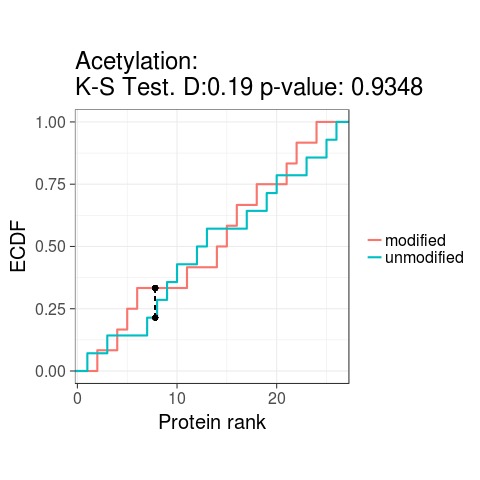

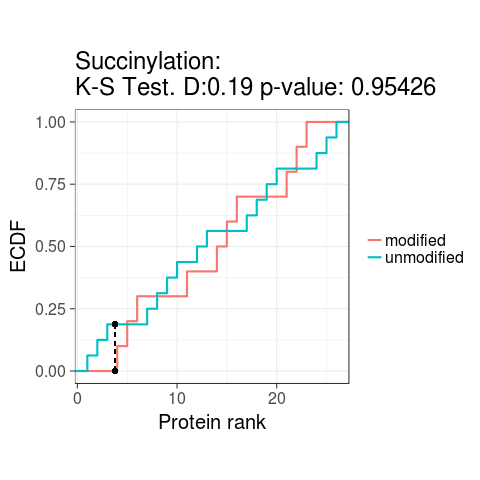

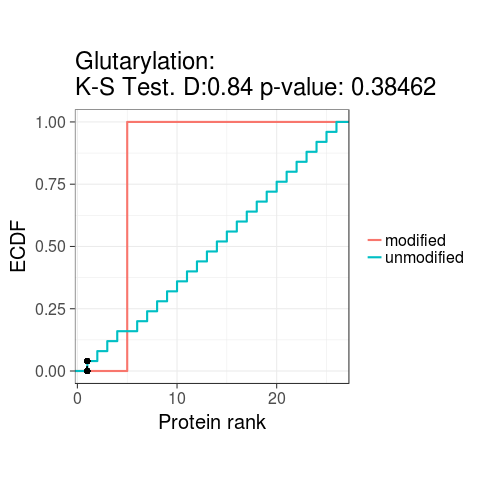

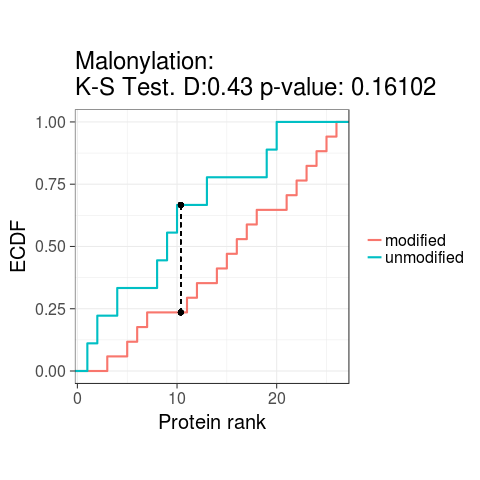

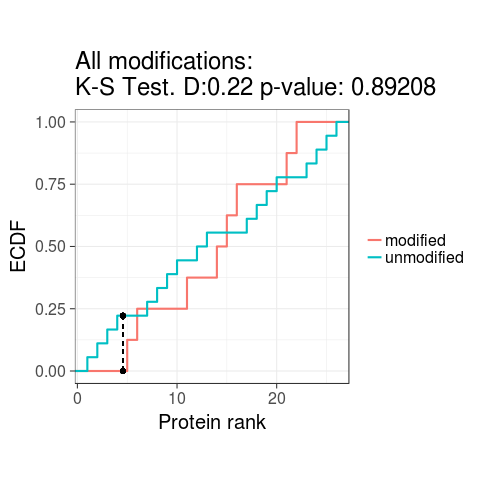

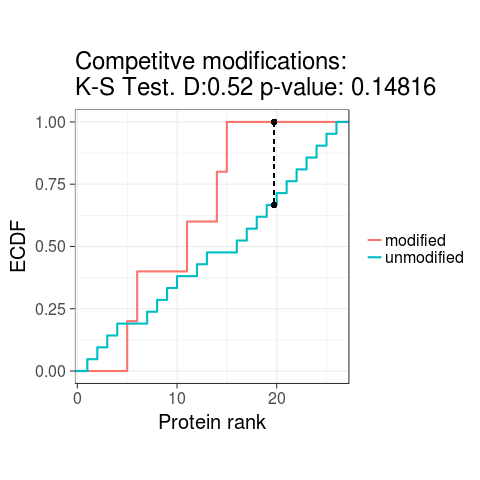

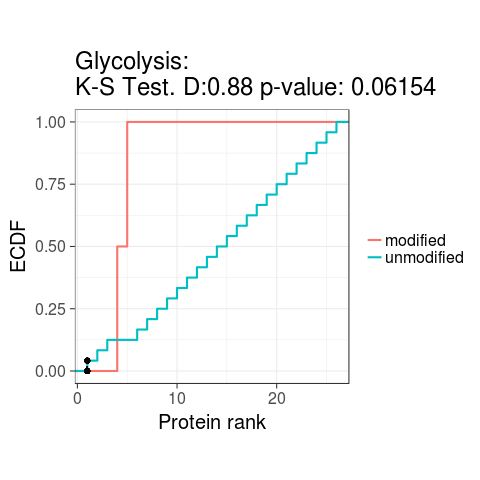

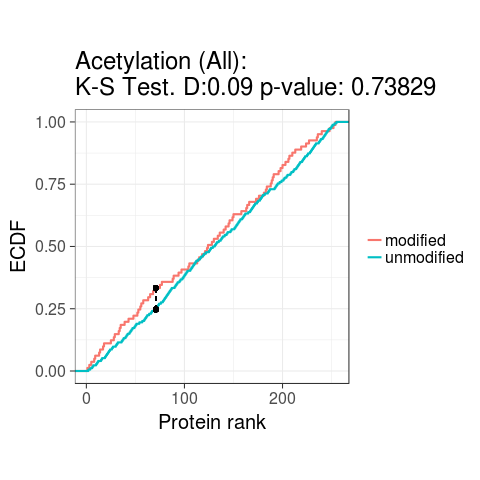

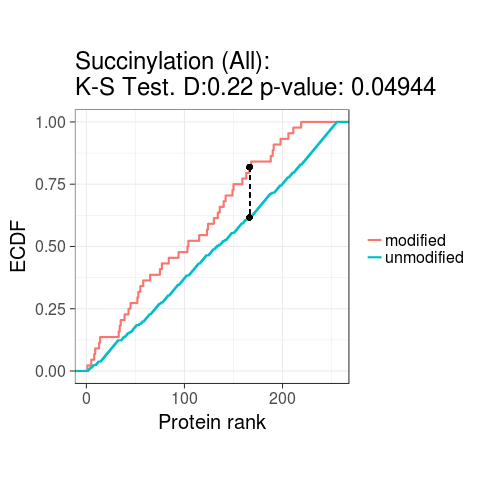

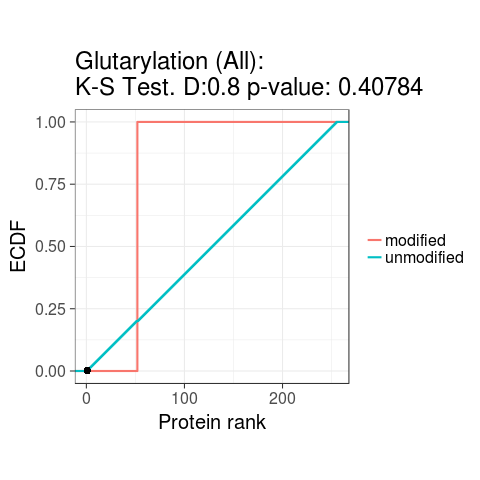

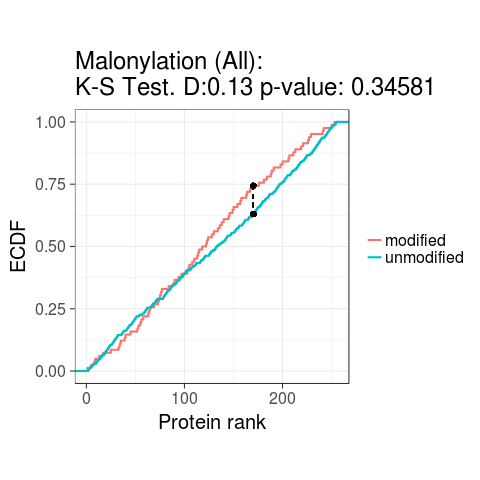

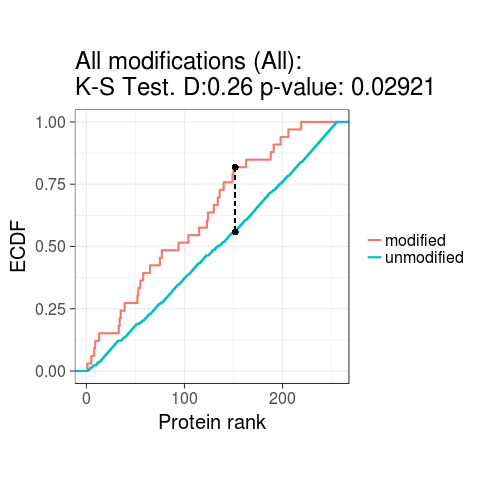

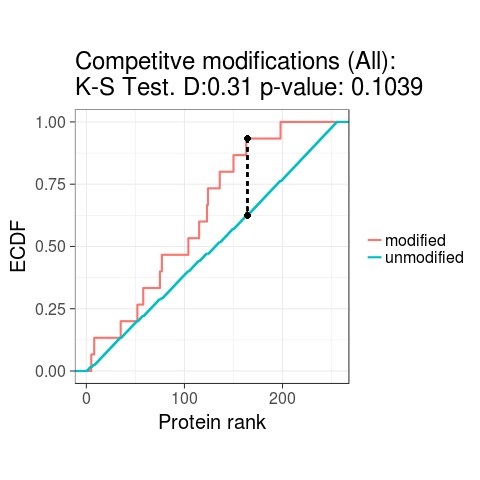

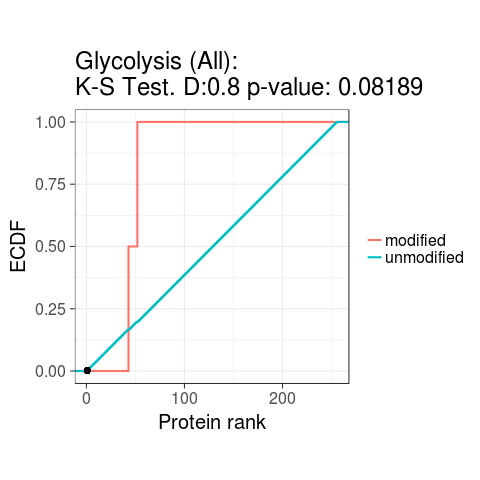

In [55]:
%%R -i ecadherin_df
print(colnames(ecadherin_df))

tmp_ecadherin_df = ecadherin_df[ecadherin_df[['Mouse_uniprot_IDs']] %in% cyt_all,]
tmp_ecadherin_all_df = ecadherin_df[ecadherin_df[['Mouse_uniprot_IDs']] %in% all,]

run_ks_test = function(df, targets, background, plotfile='', modification=''){

scores <- df$iBAQ.sum..Ctrl.EGTA.
#scores <- df$X.iBAQ#.ALL.iBAQ.ALL.sum..100....
ranking <- rank(-scores, ties.method='first')  


#numeric vectors containing the indices of your gene set in scores  
ind <- match(targets, df[['Mouse_uniprot_IDs']]) 
background_ind <- match(background[!is.element(background, targets)], df[['Mouse_uniprot_IDs']])
#background_ind <- match(background, df[['Mouse_uniprot_IDs']])

ind = ind[is.finite(ind)]
background_ind = background_ind[is.finite(background_ind)]

geneset <- ranking[ind]  

background <- ranking[background_ind]

ks = ks.test(geneset,background)
print(ks)    
    
sample1 <- geneset
sample2 <- background
group <- c(rep("sample1", length(sample1)), rep("sample2", length(sample2)))
dat <- data.frame(KSD = c(sample1,sample2), group = group)

cdf1 <- ecdf(sample1) 
cdf2 <- ecdf(sample2) 

minMax <- seq(min(sample1, sample2), max(sample1, sample2), length.out=length(sample1)) 
x0 <- minMax[which( abs(cdf1(minMax) - cdf2(minMax)) == max(abs(cdf1(minMax) - cdf2(minMax))) )] 
y0 <- cdf1(x0) 
y1 <- cdf2(x0) 

p = ggplot(dat, aes(x = KSD, group = group, color = group))+
  stat_ecdf(size=1) +
    theme_bw(base_size = 20) +
    theme(legend.position ="right") +
    xlab("Protein rank") +
    ylab("ECDF") +
    #geom_line(size=1) +
    geom_segment(aes(x = x0[1], y = y0[1], xend = x0[1], yend = y1[1]),
        linetype = "dashed", color = "black") +
    geom_point(aes(x = x0[1] , y= y0[1]), color="black", size=2) +
    geom_point(aes(x = x0[1] , y= y1[1]), color="black", size=2) +
    ggtitle(paste0(modification, ":\nK-S Test. D:", round(ks$statistic, 2), ' p-value: ', round(ks$p.value, 5)))+
    theme(legend.title=element_blank(), aspect.ratio=1) +
    scale_colour_discrete(labels=c('modified', 'unmodified'))

plot(p)
ggsave(plotfile)

return(list(geneset, background))
}

sets_acetyl <- run_ks_test(tmp_ecadherin_df, cyt_acetyl, cyt_all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_acetyl.png',
                         'Acetylation')

sets_succ <- run_ks_test(tmp_ecadherin_df, cyt_succ, cyt_all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_succ.png',
                         'Succinylation')
sets_glut <- run_ks_test(tmp_ecadherin_df, cyt_glut, cyt_all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_glut.png',
                         'Glutarylation')
sets_malon <- run_ks_test(tmp_ecadherin_df, cyt_malon, cyt_all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_malon.png',
                         'Malonylation')
sets_mod <- run_ks_test(tmp_ecadherin_df, cyt_all_mod, cyt_all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_all_mod.png',
                         'All modifications')
sets_comp <- run_ks_test(tmp_ecadherin_df, cyt_comp, cyt_all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_comp.png',
                         'Competitve modifications')
sets_cyt_gly <- run_ks_test(tmp_ecadherin_df, cyt_gly_succ, cyt_all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_cyt_gly_succ.png',
                         'Glycolysis')


sets_acetyl <- run_ks_test(tmp_ecadherin_all_df, acetyl, all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_acetyl_all.png',
                         'Acetylation (All)')

sets_succ <- run_ks_test(tmp_ecadherin_all_df, succ, all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_succ_all.png',
                         'Succinylation (All)')
sets_glut <- run_ks_test(tmp_ecadherin_all_df, glut, all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_glut_all.png',
                         'Glutarylation (All)')
sets_malon <- run_ks_test(tmp_ecadherin_all_df, malon, all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_malon_all.png',
                         'Malonylation (All)')
sets_mod <- run_ks_test(tmp_ecadherin_all_df, all_mod, all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_all_mod_all.png',
                         'All modifications (All)')
sets_comp <- run_ks_test(tmp_ecadherin_all_df, comp, all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_comp_all.png',
                         'Competitve modifications (All)')
sets_cyt_gly <- run_ks_test(tmp_ecadherin_all_df, glycolytic_enzymes, all,
                         '/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/ECDF_cyt_gly_succ_all.png',
                         'Glycolysis (All)')

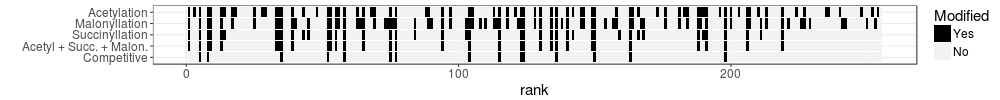

In [56]:
%%R -w 1000 -h 100



df = data.frame('rank' = sets_succ[[1]], 'Modified' = 'Yes', modification='Succinyllation')
df = rbind(df, data.frame('rank' = sets_succ[[2]], 'Modified' = 'No', modification='Succinyllation'))
df = rbind(df, data.frame('rank' = sets_malon[[1]], 'Modified' = 'Yes', modification='Malonyllation'))
df = rbind(df, data.frame('rank' = sets_malon[[2]], 'Modified' = 'No', modification='Malonyllation'))
#df = rbind(df, data.frame('rank' = sets_glut[[1]], 'Modified' = 'Yes', modification='Glutarylation'))
#df = rbind(df, data.frame('rank' = sets_glut[[2]], 'Modified' = 'No', modification='Glutarylation'))
df = rbind(df, data.frame('rank' = sets_acetyl[[1]], 'Modified' = 'Yes', modification='Acetylation'))
df = rbind(df, data.frame('rank' = sets_acetyl[[2]], 'Modified' = 'No', modification='Acetylation'))
df = rbind(df, data.frame('rank' = sets_mod[[1]], 'Modified' = 'Yes', modification='Acetyl + Succ. + Malon.'))
df = rbind(df, data.frame('rank' = sets_mod[[2]], 'Modified' = 'No', modification='Acetyl + Succ. + Malon.'))
df = rbind(df, data.frame('rank' = sets_comp[[1]], 'Modified' = 'Yes', modification='Competitive'))
df = rbind(df, data.frame('rank' = sets_comp[[2]], 'Modified' = 'No', modification='Competitive'))
#df = rbind(df, data.frame('rank' = sets_cyt_gly[[1]], 'Modified' = 'Yes',
#                          modification='Succinyllated\nglycolysis enzymes'))
#df = rbind(df, data.frame('rank' = sets_cyt_gly[[2]], 'Modified' = 'No',
#                          modification='Succinyllated\nglycolysis enzymes'))


df$modification = factor(
    df$modification, levels = c(
        'Succinyllated\nglycolysis enzymes', 'Glutarylation', 'Competitive', 'Acetyl + Succ. + Malon.',
        'Succinyllation', 'Malonyllation', 'Acetylation'))

p = ggplot(df, aes(x=rank, y=modification, fill=Modified)) +
geom_tile(height=.9) +
ylab("") + 
scale_fill_manual(values=c('black', 'grey95')) +
theme_bw() +
theme(
text = element_text(size=15))

print(p)

ggsave('/home/FILESERVER5/proteomics/tss38/WT/Lysine_mod/plots.dir/modification_ranks_in_cadherin_interactome.png',
      width=8, height=2)

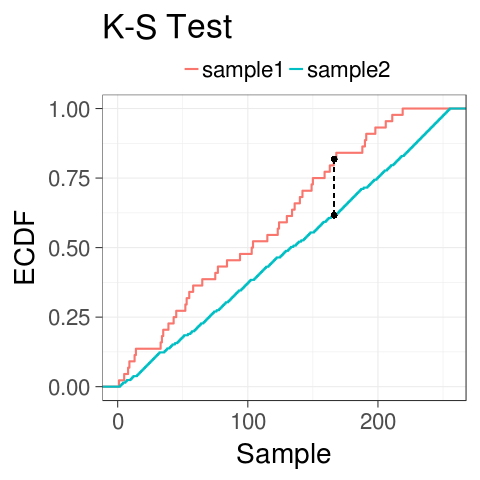

In [57]:
%%R
library(ggplot2)

plot_cdf <- function(geneset, background, plot_title){
sample1 <- geneset
sample2 <- background
group <- c(rep("sample1", length(sample1)), rep("sample2", length(sample2)))
dat <- data.frame(KSD = c(sample1,sample2), group = group)

cdf1 <- ecdf(sample1) 
cdf2 <- ecdf(sample2) 

minMax <- seq(min(sample1, sample2), max(sample1, sample2), length.out=length(sample1)) 
x0 <- minMax[which( abs(cdf1(minMax) - cdf2(minMax)) == max(abs(cdf1(minMax) - cdf2(minMax))) )] 
y0 <- cdf1(x0) 
y1 <- cdf2(x0) 

p = ggplot(dat, aes(x = KSD, group = group, color = group))+
  stat_ecdf(size=1) +
    theme_bw(base_size = 28) +
    theme(legend.position ="top") +
    xlab("Sample") +
    ylab("ECDF") +
    #geom_line(size=1) +
    geom_segment(aes(x = x0[1], y = y0[1], xend = x0[1], yend = y1[1]),
        linetype = "dashed", color = "black") +
    geom_point(aes(x = x0[1] , y= y0[1]), color="black", size=2) +
    geom_point(aes(x = x0[1] , y= y1[1]), color="black", size=2) +
    ggtitle("K-S Test") +
    theme(legend.title=element_blank())

plot(p)

}

plot_cdf(sets_succ[[1]], sets_succ[[2]], '')

In [58]:
cadherin_adhesome_df = pd.read_table("../raw/Cadherin_adhesome.csv", sep="\t")


mm_uniprot_ids = []

for protein in cadherin_adhesome_df['UniProt ID']:
    protein = protein.replace(" ", "")
    if protein in mm2hg:
        mm_uniprot_ids.append(mm2hg[protein])
    else:
        mm_uniprot_ids.append("")

cadherin_adhesome_df['Mouse_uniprot_IDs'] = mm_uniprot_ids

print(cadherin_adhesome_df.head())
print(cadherin_adhesome_df['Mouse_uniprot_IDs'])

  Gene name               protein name  \
0     ACTN1            Alpha-actinin-1   
1     ACTN4           actinin, alpha 4   
2      ADD1              Alpha-Adducin   
3     AKAP5  A kinase anchor protein 5   
4    CTNNA1           Catenin alpha 1    

                                     alternate names UniProt ID  \
0  Alpha-actinin cytoskeletal isoform\nF-actin cr...     P12814   
1                       alpha-actinin-4, FSGS1, FSGS     O43707   
2                  Erythrocyte adducin subunit alpha     P35611   
3      A-kinase anchor protein 5\n    AKAP-5\n   ...     P24588   
4  Alpha E catenin; Cadherin associated protein; ...     P35221   

                                            sequence  Length (AA)  \
0  MDHYDSQQTNDYMQPEEDWDRDLLLDPAWEKQQRKTFTAWCNSHLR...        892.0   
1  MVDYHAANQSYQYGPSSAGNGAGGGGSMGDYMAQEDDWDRDLLLDP...        911.0   
2  MNGDSRAAVVTSPPPTTAPHKERYFDRVDENNPEYLRERNMAPDLR...        737.0   
3  METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...        427.0   

In [59]:
print(sum(cadherin_adhesome_df['Mouse_uniprot_IDs']!=""))

76


In [60]:
from bioservices import UniProt
u = UniProt()

u_results = u.search("organism:10090+and+reviewed:yes", columns="id,entry name", limit=-1)

In [61]:
uniprot_ids_df = pd.DataFrame.from_records(
        [x.split() for x in u_results.strip().split("\n")[1:]],
        columns=["uniprot_id", "name"])

print(uniprot_ids_df.head())
print(uniprot_ids_df.shape)

  uniprot_id         name
0     Q02248  CTNB1_MOUSE
1     Q62226    SHH_MOUSE
2     Q01705  NOTC1_MOUSE
3     P22725  WNT5A_MOUSE
4     P10417   BCL2_MOUSE
(16853, 2)


In [62]:
lysine_df_pivot['ID'] = lysine_df_pivot.index
all_uniprot_id_df = pd.merge(lysine_df_pivot, uniprot_ids_df,
         left_on='ID', right_on='uniprot_id', how='right')

print(all_uniprot_id_df.shape)
print(all_uniprot_id_df[all_uniprot_id_df['succinylation']==1].shape)
acet_prot = all_uniprot_id_df[all_uniprot_id_df['acetylation']==1]['uniprot_id'].tolist()
succ_prot = all_uniprot_id_df[all_uniprot_id_df['succinylation']==1]['uniprot_id'].tolist()
glut_prot = all_uniprot_id_df[all_uniprot_id_df['glutarylation']==1]['uniprot_id'].tolist()
malon_prot = all_uniprot_id_df[all_uniprot_id_df['malonylation']==1]['uniprot_id'].tolist()
all_prot = all_uniprot_id_df['uniprot_id'].tolist()

print(len(acet_prot))

print(len(succ_prot))

print(len(glut_prot))

print(len(malon_prot))

print(acet_prot[0:10])
print(succ_prot[0:10])
print(glut_prot[0:10])
print(all_prot[0:10])
print(set(map(type, all_prot)))
for x in all_prot:
    if type(x) == float:
        print(x)

(16853, 10)
(831, 10)
1588
831
172
1243
['A2A791', 'A2A8Z1', 'A2AJL3', 'A2AJT4', 'A2AKK5', 'A2AN08', 'A2AQ19', 'A2AS89', 'A2ASZ8', 'A2ATU0']
['A2AKK5', 'A2AS89', 'A2ATU0', 'A6H5Y3', 'B1AR13', 'B1AXP6', 'B2RQC6', 'D3Z4S3', 'D3Z7P3', 'G3X982']
['A2ATU0', 'E9Q816', 'O08756', 'O08997', 'O35459', 'O35490', 'O35943', 'O88986', 'P00329', 'P01942']
['A0JNU3', 'A1EGX6', 'A2A432', 'A2A791', 'A2A8U2', 'A2A8Z1', 'A2AJL3', 'A2AJT4', 'A2AKK5', 'A2ALK8']
{<class 'str'>}


In [63]:
with IOTools.openFile(os.path.join(results, "malon_prot.tsv"), "w") as outf:
    outf.write("\n".join(malon_prot))
    
with IOTools.openFile(os.path.join(results, "succ_prot.tsv"), "w") as outf:
    outf.write("\n".join(succ_prot))
    
with IOTools.openFile(os.path.join(results, "glut_prot.tsv"), "w") as outf:
    outf.write("\n".join(glut_prot))
    
with IOTools.openFile(os.path.join(results, "acet_prot.tsv"), "w") as outf:
    outf.write("\n".join(acet_prot))

with IOTools.openFile(os.path.join(results, "all_prot.tsv"), "w") as outf:
    outf.write("\n".join(all_prot))
    
    

In [64]:
cadherin_adhesome_df = cadherin_adhesome_df[['UniProt ID', 'Mouse_uniprot_IDs']]
cadherin_adhesome_df['cadherin_adhesome'] = 1
lysine_df_pivot['ID'] = lysine_df_pivot.index
print(lysine_df_pivot.shape)
print(uniprot_ids_df.shape)
merged_adhesome_mod_df = pd.merge(lysine_df_pivot, uniprot_ids_df,
                                  left_on='ID', right_on='uniprot_id', how='right')
print(merged_adhesome_mod_df.shape)
merged_adhesome_mod_df = pd.merge(merged_adhesome_mod_df, cadherin_adhesome_df,
                                  left_on='uniprot_id', right_on="Mouse_uniprot_IDs", how='left')
print(sum(merged_adhesome_mod_df['Mouse_uniprot_IDs']!=""))

print(merged_adhesome_mod_df.shape)
merged_adhesome_mod_df = merged_adhesome_mod_df.fillna(0)
print(sum(merged_adhesome_mod_df['Mouse_uniprot_IDs']!=0))
print(merged_adhesome_mod_df[merged_adhesome_mod_df['cadherin_adhesome']==1].shape)
print(merged_adhesome_mod_df[merged_adhesome_mod_df['cadherin_adhesome']==0].shape)
print(merged_adhesome_mod_df.head())




(4367, 8)
(16853, 2)
(16853, 10)
16853
(16853, 13)
76
(76, 13)
(16777, 13)
Modification  acetylation  glutarylation  malonylation  succinylation  \
0                     0.0            0.0           1.0            0.0   
1                     0.0            0.0           0.0            0.0   
2                     0.0            0.0           1.0            0.0   
3                     1.0            0.0           1.0            0.0   
4                     0.0            0.0           1.0            0.0   

Modification  succinylation_SIRT5_KO  all_modifications  \
0                                0.0                0.0   
1                                1.0                0.0   
2                                0.0                0.0   
3                                0.0                0.0   
4                                0.0                0.0   

Modification  competitive_modifications      ID uniprot_id         name  \
0                                   0.0  A0JNU3     A0JN

In [65]:
%%R -i merged_adhesome_mod_df
final_df <- merged_adhesome_mod_df

In [66]:
%%R
print(table(final_df$acetylation, final_df$cadherin_adhesome))
print(table(final_df$succinylation, final_df$cadherin_adhesome))
print(table(final_df$malonylation, final_df$cadherin_adhesome))
print(table(final_df$glutarylation, final_df$cadherin_adhesome))
print(table(final_df$competitive_modifications, final_df$cadherin_adhesome))

print(fisher.test(table(final_df$acetylation, final_df$cadherin_adhesome)))
print(fisher.test(table(final_df$succinylation, final_df$cadherin_adhesome)))
print(fisher.test(table(final_df$malonylation, final_df$cadherin_adhesome)))
print(fisher.test(table(final_df$glutarylation, final_df$cadherin_adhesome)))
print(fisher.test(table(final_df$competitive_modifications, final_df$cadherin_adhesome)))

   
        0     1
  0 15217    48
  1  1560    28
   
        0     1
  0 15961    61
  1   816    15
   
        0     1
  0 15552    58
  1  1225    18
   
        0     1
  0 16605    76
  1   172     0
   
        0     1
  0 16536    73
  1   241     3

	Fisher's Exact Test for Count Data

data:  table(final_df$acetylation, final_df$cadherin_adhesome)
p-value = 8.481e-11
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 3.426061 9.283100
sample estimates:
odds ratio 
  5.688872 


	Fisher's Exact Test for Count Data

data:  table(final_df$succinylation, final_df$cadherin_adhesome)
p-value = 3.705e-06
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 2.527008 8.608510
sample estimates:
odds ratio 
  4.808379 


	Fisher's Exact Test for Count Data

data:  table(final_df$malonylation, final_df$cadherin_adhesome)
p-value = 7.565e-06
alternative hypothesis: true odds ratio is not equal to 1
95 percent c

In [67]:
%%R
cadherin_adhesome_df = read.table("../raw/Cadherin_adhesome.csv", header=T, sep="\t")
cadherin_adhesome_df = cadherin_adhesome_df[,c('UniProt.ID', 'category')]
cadherin_adhesome_df['cadherin_adhesome'] = 1

print(dim(merged_df))
print(head(merged_df))
print(head(cadherin_adhesome_df))
final_df = merge(merged_df, cadherin_adhesome_df,
                 by.x='uniprot.accession', by.y='UniProt.ID',
                 all.x=TRUE)
print(dim(final_df))
print(head(final_df))


print(dim(final_df[final_df$cadherin_adhesome==1,]))
print(dim(final_df[is.na(final_df$cadherin_adhesome),]))
print(dim(final_df[!is.na(final_df$cadherin_adhesome),]))




[1] 4413    9
       uniprot.accession Final.Localization.Assignment acetylation
A2A432            A2A432                  unclassified           0
A2A4P0            A2A4P0       Nucleus - Non-chromatin           0
A2A5R2            A2A5R2                  unclassified           0
A2A791            A2A791           Nucleus - Chromatin           1
A2A8L5            A2A8L5               Plasma membrane           0
A2A8Z1            A2A8Z1                  unclassified           1
       glutarylation malonylation succinylation succinylation_SIRT5_KO
A2A432             0            1             0                      0
A2A4P0             0            0             0                      0
A2A5R2             0            0             0                      0
A2A791             0            1             0                      0
A2A8L5             0            0             0                      0
A2A8Z1             0            0             0                      0
       all_modificat

In [68]:
print(lysine_df_pivot2.head())
print(max(lysine_df_pivot2['succinylation']))

Modification      acetylation  malonylation  succinylation  \
Protein Position                                             
A0AUV1  5.0                 1             0              0   
        9.0                 1             0              0   
        95.0                1             0              0   
        118.0               1             0              0   
A0JLP6  335.0               1             0              0   

Modification      succinylation_SIRT5_KO  
Protein Position                          
A0AUV1  5.0                            0  
        9.0                            0  
        95.0                           0  
        118.0                          0  
A0JLP6  335.0                          0  
1
